# Case Study: Identifying streets with the most street flooding complaints

Mark Bauer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import contextily as ctx

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing verions of Python modules and packages with **watermark** - the IPython magic extension.  
Documention for installing watermark: https://github.com/rasbt/watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,geopandas,matplotlib.pyplot,matplotlib,seaborn,fiona,contextily

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy            : 1.22.4
pandas           : 1.4.2
geopandas        : 0.9.0
matplotlib.pyplot: unknown
matplotlib       : 3.5.2
seaborn          : 0.11.2
fiona            : 1.8.21
contextily       : 1.3.0



# Read in Data

In [3]:
# list items in data folder
%ls data/

README.md                       street-flooding-query.csv
street-flooding-complaints.csv  streets-clipped.gpkg


## Street Flooding Complaints

In [4]:
# read data as a dataframe
df = pd.read_csv('data/street-flooding-complaints.csv', low_memory=False)

# preview data
print(df.shape)
df.head()

(24817, 27)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_borough,latitude,longitude,location
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,02 STATEN ISLAND,5.037950e+09,STATEN ISLAND,958363.0,148793.0,ONLINE,STATEN ISLAND,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':..."
1,45283863,2019-12-31T17:34:00.000,2020-01-01T15:45:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10312.0,NaN,NaN,...,03 STATEN ISLAND,NaN,STATEN ISLAND,937878.0,143517.0,PHONE,STATEN ISLAND,40.560476,-74.166889,"{'latitude': '40.56047555908232', 'longitude':..."
2,45279400,2019-12-31T16:11:00.000,2020-01-08T10:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10305.0,753 QUINCY AVENUE,QUINCY AVENUE,...,02 STATEN ISLAND,5.038260e+09,STATEN ISLAND,960864.0,149333.0,PHONE,STATEN ISLAND,40.576530,-74.084185,"{'latitude': '40.576529751013474', 'longitude'..."
3,45277773,2019-12-31T15:42:00.000,2020-01-01T05:25:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11379.0,61-21 70 STREET,70 STREET,...,05 QUEENS,4.029270e+09,QUEENS,1015410.0,201741.0,PHONE,QUEENS,40.720354,-73.887589,"{'latitude': '40.72035428730757', 'longitude':..."
4,45282532,2019-12-31T12:18:00.000,2019-12-31T14:15:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11375.0,NaN,NaN,...,06 QUEENS,NaN,QUEENS,1027498.0,202160.0,PHONE,QUEENS,40.721454,-73.843978,"{'latitude': '40.721453503515995', 'longitude'..."


In [5]:
# printing the column names, non-null counts, and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24817 entries, 0 to 24816
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      24817 non-null  int64  
 1   created_date                    24817 non-null  object 
 2   closed_date                     24815 non-null  object 
 3   agency                          24817 non-null  object 
 4   agency_name                     24817 non-null  object 
 5   complaint_type                  24817 non-null  object 
 6   descriptor                      24817 non-null  object 
 7   incident_zip                    24817 non-null  float64
 8   incident_address                16002 non-null  object 
 9   street_name                     16002 non-null  object 
 10  cross_street_1                  21821 non-null  object 
 11  cross_street_2                  21816 non-null  object 
 12  address_type                    

## Neighborhood Tabulation Areas (NTAs)

In [6]:
# importing nta boundaries
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
nta_gdf = gpd.read_file(url)
nta_gdf = nta_gdf.to_crs(epsg=2263)

# previewing first five rows in data
print('shape of data: {}'.format(nta_gdf.shape[0]))
nta_gdf.head()

shape of data: 195


,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,QN08,77412747.847,081,St. Albans,45401.316803,Queens,4,"MULTIPOLYGON (((1052996.196 196307.658, 105308..."
1,BX28,25666124.5948,005,Van Cortlandt Village,21945.719299,Bronx,2,"MULTIPOLYGON (((1015481.837 261490.578, 101548..."
2,QN55,82461393.7368,081,South Ozone Park,36708.1693055,Queens,4,"MULTIPOLYGON (((1038120.503 188147.096, 103819..."
3,BK50,82089678.6389,047,Canarsie,43703.6096661,Brooklyn,3,"MULTIPOLYGON (((1015236.151 174910.303, 101523..."
4,BX41,14716710.7402,005,Mount Hope,18937.247819,Bronx,2,"MULTIPOLYGON (((1013128.525 250637.931, 101284..."


<AxesSubplot:>

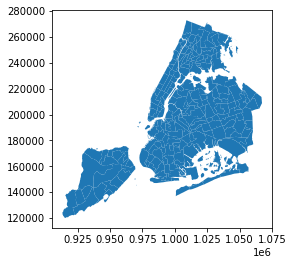

In [7]:
nta_gdf.plot()

## Streets

In [8]:
path = 'data/streets-clipped.gpkg'
streets = gpd.read_file(path)

print('shape of data: {}'.format(streets.shape))
print('street id is unique: {}'.format(streets['physicalid'].is_unique))
print(streets.crs)

streets.head()

shape of data: (99124, 12)
street id is unique: True
epsg:2263


,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry
0,-1,BRUCKNER BLVD,BRUCKNER,BRUCKNER BLVD,1,Street,36.0,13,13,2,522.161372,"LINESTRING (1010270.223 233448.310, 1010354.99..."
1,10000,25 AVE,25,25 AVE,1,Street,35.0,13,13,4,254.863947,"LINESTRING (1019770.393 217876.440, 1020022.80..."
2,100000,233 PL,233,233 PL,1,Street,25.0,13,13,4,272.837036,"LINESTRING (1052461.825 220583.306, 1052572.26..."
3,100001,MILBURN ST,MILBURN,MILBURN ST,1,Street,30.0,13,13,4,485.074277,"LINESTRING (1051561.903 187846.554, 1051902.84..."
4,100003,92 AVE,92,92 AVE,1,Street,30.0,13,13,4,524.426714,"LINESTRING (1057729.808 204117.541, 1058232.69..."


In [9]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99124 entries, 0 to 99123
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99124 non-null  object  
 1   st_label      99124 non-null  object  
 2   st_name       99124 non-null  object  
 3   full_stree    99124 non-null  object  
 4   rw_type       99124 non-null  object  
 5   rw_type_name  99124 non-null  object  
 6   st_width      99124 non-null  object  
 7   frm_lvl_co    99124 non-null  object  
 8   to_lvl_co     99124 non-null  object  
 9   borocode      99124 non-null  object  
 10  shape_leng    99124 non-null  float64 
 11  geometry      99124 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [10]:
# Examine counts of geom types
streets.geom_type.value_counts()

LineString    99124
dtype: int64

<AxesSubplot:>

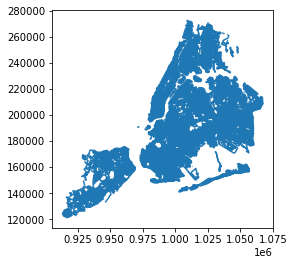

In [11]:
# sanity check plot
streets.plot()

# Mapping

# Case Studies

- Hammels, Arverne, and Edgemere, Queens
- New Dorp - Midland Beach, Staten Island

In [12]:
geometry = gpd.points_from_xy(df['x_coordinate_state_plane'], df['y_coordinate_state_plane'])
top_nta = gpd.GeoDataFrame(df, geometry=geometry, crs=2263)

top_nta = gpd.sjoin(
    top_nta, 
    nta_gdf, 
    how="inner", 
    op='within'
)

top_nta.head()

/Users/markbauer/opt/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,location,geometry,index_right,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5
9,45279697,2019-12-31T07:10:00.000,2019-12-31T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5
68,45196140,2019-12-18T15:58:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,101 3 STREET,3 STREET,...,"{'latitude': '40.57522353925495', 'longitude':...",POINT (951437.000 148868.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5
79,45188340,2019-12-18T10:16:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,15 LISBON PLACE,LISBON PLACE,...,"{'latitude': '40.5817739850288', 'longitude': ...",POINT (954138.000 151251.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5
80,45188337,2019-12-18T09:30:00.000,2019-12-18T19:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5


# Neighborhoods with the Most Street Flooding Complaints

In [13]:
(top_nta
 .groupby(by='ntaname')['unique_key']
 .count()
 .rename('count')
 .reset_index()
 .sort_values('count', ascending=False)
 .head(10)
)

,ntaname,count
116,New Dorp-Midland Beach,690
80,Hammels-Arverne-Edgemere,662
97,Lindenwood-Howard Beach,566
157,St. Albans,550
61,Far Rockaway-Bayswater,520
17,Borough Park,501
127,Old Town-Dongan Hills-South Beach,500
76,Great Kills,484
143,Rosedale,439
123,Oakwood-Oakwood Beach,396


## Hammels, Arverne, and Edgemere, Queens

In [14]:
geometry = gpd.points_from_xy(df['x_coordinate_state_plane'], df['y_coordinate_state_plane'])
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=2263)

gdf.head()

/Users/markbauer/opt/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_borough,latitude,longitude,location,geometry
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,5.037950e+09,STATEN ISLAND,958363.0,148793.0,ONLINE,STATEN ISLAND,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000)
1,45283863,2019-12-31T17:34:00.000,2020-01-01T15:45:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10312.0,NaN,NaN,...,NaN,STATEN ISLAND,937878.0,143517.0,PHONE,STATEN ISLAND,40.560476,-74.166889,"{'latitude': '40.56047555908232', 'longitude':...",POINT (937878.000 143517.000)
2,45279400,2019-12-31T16:11:00.000,2020-01-08T10:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10305.0,753 QUINCY AVENUE,QUINCY AVENUE,...,5.038260e+09,STATEN ISLAND,960864.0,149333.0,PHONE,STATEN ISLAND,40.576530,-74.084185,"{'latitude': '40.576529751013474', 'longitude'...",POINT (960864.000 149333.000)
3,45277773,2019-12-31T15:42:00.000,2020-01-01T05:25:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11379.0,61-21 70 STREET,70 STREET,...,4.029270e+09,QUEENS,1015410.0,201741.0,PHONE,QUEENS,40.720354,-73.887589,"{'latitude': '40.72035428730757', 'longitude':...",POINT (1015410.000 201741.000)
4,45282532,2019-12-31T12:18:00.000,2019-12-31T14:15:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11375.0,NaN,NaN,...,NaN,QUEENS,1027498.0,202160.0,PHONE,QUEENS,40.721454,-73.843978,"{'latitude': '40.721453503515995', 'longitude'...",POINT (1027498.000 202160.000)


In [15]:
ls data/

README.md                       street-flooding-query.csv
street-flooding-complaints.csv  streets-clipped.gpkg


In [16]:
path = 'data/streets-clipped.gpkg'
streets = gpd.read_file(path)

streets.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry
0,-1,BRUCKNER BLVD,BRUCKNER,BRUCKNER BLVD,1,Street,36.0,13,13,2,522.161372,"LINESTRING (1010270.223 233448.310, 1010354.99..."
1,10000,25 AVE,25,25 AVE,1,Street,35.0,13,13,4,254.863947,"LINESTRING (1019770.393 217876.440, 1020022.80..."
2,100000,233 PL,233,233 PL,1,Street,25.0,13,13,4,272.837036,"LINESTRING (1052461.825 220583.306, 1052572.26..."
3,100001,MILBURN ST,MILBURN,MILBURN ST,1,Street,30.0,13,13,4,485.074277,"LINESTRING (1051561.903 187846.554, 1051902.84..."
4,100003,92 AVE,92,92 AVE,1,Street,30.0,13,13,4,524.426714,"LINESTRING (1057729.808 204117.541, 1058232.69..."


In [17]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99124 entries, 0 to 99123
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99124 non-null  object  
 1   st_label      99124 non-null  object  
 2   st_name       99124 non-null  object  
 3   full_stree    99124 non-null  object  
 4   rw_type       99124 non-null  object  
 5   rw_type_name  99124 non-null  object  
 6   st_width      99124 non-null  object  
 7   frm_lvl_co    99124 non-null  object  
 8   to_lvl_co     99124 non-null  object  
 9   borocode      99124 non-null  object  
 10  shape_leng    99124 non-null  float64 
 11  geometry      99124 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


<AxesSubplot:>

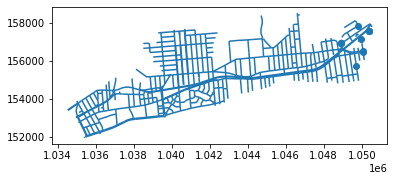

In [18]:
Hammels_Arverne_Edgemere = (
    nta_gdf
    .loc[nta_gdf['ntaname'] == 'Hammels-Arverne-Edgemere']
    .reset_index(drop=True)
)

# clipping the points that only fall within the nta shapes
streets_clipped = gpd.clip(
    streets,
    Hammels_Arverne_Edgemere
)

streets_clipped.plot()

In [19]:
streets_clipped.geom_type.value_counts()

LineString            873
Point                  10
MultiLineString         4
GeometryCollection      1
dtype: int64

In [20]:
streets_clipped = (
    streets_clipped
    .loc[streets_clipped.geom_type == 'LineString']
    .reset_index(drop=True)
)

streets_clipped.geom_type.value_counts()

LineString    873
dtype: int64

<AxesSubplot:>

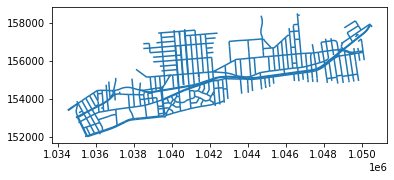

In [21]:
streets_clipped.plot()

<AxesSubplot:>

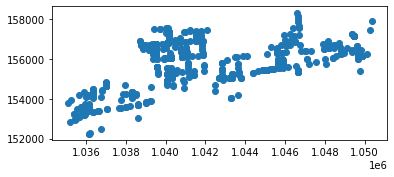

In [22]:
# clipping the points that only fall within the nta shapes
Hammels_Arverne_Edgemere = gpd.clip(
    gdf,
    Hammels_Arverne_Edgemere
)

Hammels_Arverne_Edgemere.plot()

# Snap Points to Streets

Source: https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

In [23]:
offset = 80
bbox = Hammels_Arverne_Edgemere.bounds + [-offset, -offset, offset, offset]
hits = bbox.apply(lambda row: list(streets_clipped.sindex.intersection(row)), axis=1)

tmp = pd.DataFrame({
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    "line_i": np.concatenate(hits.values)
})

tmp.head()

,pt_idx,line_i
0,5,698.0
1,6,589.0
2,6,219.0
3,6,520.0
4,6,218.0


In [24]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(
    streets_clipped.reset_index(drop=True), 
    on="line_i"
)

tmp.head()

,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry
0,5,698.0,199032,BCH 84 ST,84,BCH 84 ST,1,Street,20.0,13,13,4,672.269096,"LINESTRING (1036946.071 154458.499, 1037059.28..."
1,6,589.0,180192,BCH 44 ST,44,BCH 44 ST,1,Street,30.0,13,13,4,411.513556,"LINESTRING (1046695.209 154941.102, 1046655.97..."
2,6,219.0,14303,EDGEMERE AVE,EDGEMERE,EDGEMERE AVE,1,Street,30.0,13,13,4,229.491361,"LINESTRING (1046655.970 155350.740, 1046428.40..."
3,6,520.0,168689,ROCKAWAY FWY,ROCKAWAY,ROCKAWAY FWY,1,Street,25.0,13,13,4,713.560780,"LINESTRING (1046651.425 155407.678, 1046457.06..."
4,6,218.0,14302,EDGEMERE AVE,EDGEMERE,EDGEMERE AVE,1,Street,30.0,13,13,4,236.667195,"LINESTRING (1046890.559 155382.030, 1046655.97..."


In [25]:
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(
    Hammels_Arverne_Edgemere.geometry.rename("point"), 
    on="pt_idx"
)

# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(
    tmp, 
    geometry="geometry", 
    crs=Hammels_Arverne_Edgemere.crs
)

tmp.head()

,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point
0,5,698.0,199032,BCH 84 ST,84,BCH 84 ST,1,Street,20.0,13,13,4,672.269096,"LINESTRING (1036946.071 154458.499, 1037059.28...",POINT (1037027.000 154813.000)
1,6,589.0,180192,BCH 44 ST,44,BCH 44 ST,1,Street,30.0,13,13,4,411.513556,"LINESTRING (1046695.209 154941.102, 1046655.97...",POINT (1046656.000 155350.000)
2,6,219.0,14303,EDGEMERE AVE,EDGEMERE,EDGEMERE AVE,1,Street,30.0,13,13,4,229.491361,"LINESTRING (1046655.970 155350.740, 1046428.40...",POINT (1046656.000 155350.000)
3,6,520.0,168689,ROCKAWAY FWY,ROCKAWAY,ROCKAWAY FWY,1,Street,25.0,13,13,4,713.560780,"LINESTRING (1046651.425 155407.678, 1046457.06...",POINT (1046656.000 155350.000)
4,6,218.0,14302,EDGEMERE AVE,EDGEMERE,EDGEMERE AVE,1,Street,30.0,13,13,4,236.667195,"LINESTRING (1046890.559 155382.030, 1046655.97...",POINT (1046656.000 155350.000)


In [26]:
tmp["snap_dist"] = tmp['geometry'].distance(gpd.GeoSeries(tmp.point))

# Discard any lines that are greater than tolerance from points
# Sort on ascending snap distance, so that closest goes to top
tmp = (
    tmp
    .loc[tmp.snap_dist <= offset]
    .sort_values(by=["snap_dist"])
)

tmp.head()

,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
714,8444,510.0,168597,BCH 38 ST,38,BCH 38 ST,1,Street,32.0,13,13,4,130.294393,"LINESTRING (1048048.494 155857.248, 1048025.90...",POINT (1048026.000 155985.000),0.008927
1654,18044,674.0,197523,BCH 88 ST,88,BCH 88 ST,1,Street,30.0,13,13,4,50.091305,"LINESTRING (1036149.133 153656.343, 1036144.96...",POINT (1036145.000 153706.000),0.011066
2056,24202,24.0,104191,BCH 63 ST,63,BCH 63 ST,1,Street,30.0,13,13,4,395.083951,"LINESTRING (1041962.214 155024.238, 1041926.94...",POINT (1041927.000 155417.000),0.011800
515,6746,231.0,14316,EDGEMERE AVE,EDGEMERE,EDGEMERE AVE,1,Street,32.0,13,13,4,248.362836,"LINESTRING (1049367.344 156350.038, 1049121.55...",POINT (1049367.000 156350.000),0.011995
1625,17920,131.0,14055,ROCKAWAY BEACH BLVD,ROCKAWAY BEACH,ROCKAWAY BEACH BLVD,1,Street,60.0,13,13,4,243.362356,"LINESTRING (1036175.788 153314.985, 1035951.77...",POINT (1035952.000 153220.000),0.017190


In [27]:
# group by the index of the points and take the first, which is the closest line 
closest = tmp.groupby("pt_idx").first()
closest = gpd.GeoDataFrame(closest, geometry="geometry")

# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))
# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

/Users/markbauer/opt/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/array.py:640: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vectorized.interpolate(self.data, distance, normalized=normalized),


pt_idx
5      POINT (1037023.858 154813.688)
6      POINT (1046656.040 155350.004)
28     POINT (1040075.192 156788.580)
33     POINT (1037023.858 154813.688)
135    POINT (1041879.776 156929.268)
dtype: geometry

In [28]:
# Create a new GeoDataFrame from the columns from the closest line and 
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
pt_idx,,,,,,,,,,,,,,,
5,698.0,199032,BCH 84 ST,84,BCH 84 ST,1,Street,20.0,13,13,4,672.269096,POINT (1037023.858 154813.688),POINT (1037027.000 154813.000),3.216407
6,589.0,180192,BCH 44 ST,44,BCH 44 ST,1,Street,30.0,13,13,4,411.513556,POINT (1046656.040 155350.004),POINT (1046656.000 155350.000),0.040469
28,153.0,14103,ALMEDA AVE,ALMEDA,ALMEDA AVE,1,Street,32.0,13,13,4,699.628862,POINT (1040075.192 156788.580),POINT (1040075.000 156791.000),2.427670
33,698.0,199032,BCH 84 ST,84,BCH 84 ST,1,Street,20.0,13,13,4,672.269096,POINT (1037023.858 154813.688),POINT (1037027.000 154813.000),3.216407
135,594.0,180494,ALMEDA AVE,ALMEDA,ALMEDA AVE,1,Street,30.0,13,13,4,410.828109,POINT (1041879.776 156929.268),POINT (1041880.000 156926.000),3.275961


In [29]:
# Join back to the original points:
updated_points = (
    Hammels_Arverne_Edgemere
    .drop(columns=["geometry"])
    .join(snapped)
    .dropna(subset=["geometry"])
)

updated_points.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
5,45281575,2019-12-31T12:00:00.000,2019-12-31T16:36:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11693.0,340 BEACH 84 STREET,BEACH 84 STREET,...,1,Street,20.0,13,13,4,672.269096,POINT (1037023.858 154813.688),POINT (1037027.000 154813.000),3.216407
6,45284233,2019-12-31T09:57:00.000,2020-01-02T08:40:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11691.0,NaN,NaN,...,1,Street,30.0,13,13,4,411.513556,POINT (1046656.040 155350.004),POINT (1046656.000 155350.000),0.040469
28,45276746,2019-12-30T12:02:00.000,2020-01-08T10:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11692.0,69-62 ALMEDA AVENUE,ALMEDA AVENUE,...,1,Street,32.0,13,13,4,699.628862,POINT (1040075.192 156788.580),POINT (1040075.000 156791.000),2.427670
33,45273779,2019-12-30T10:39:00.000,2020-01-08T09:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11693.0,340 BEACH 84 STREET,BEACH 84 STREET,...,1,Street,20.0,13,13,4,672.269096,POINT (1037023.858 154813.688),POINT (1037027.000 154813.000),3.216407
135,45180730,2019-12-17T10:31:00.000,2019-12-18T11:25:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11692.0,62-07 ALMEDA AVENUE,ALMEDA AVENUE,...,1,Street,30.0,13,13,4,410.828109,POINT (1041879.776 156929.268),POINT (1041880.000 156926.000),3.275961


In [30]:
updated_points.sort_values(by='snap_dist').head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
8444,36413999,2017-06-11T14:59:00.000,2017-06-13T10:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11691.0,NaN,NaN,...,1,Street,32.0,13,13,4,130.294393,POINT (1048026.009 155985.002),POINT (1048026.000 155985.000),0.008927
18044,24622666,2012-12-18T05:33:00.000,2012-12-18T11:18:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11693.0,NaN,NaN,...,1,Street,30.0,13,13,4,50.091305,POINT (1036144.989 153705.999),POINT (1036145.000 153706.000),0.011066
24202,16343334,2010-03-30T08:55:00.000,2010-03-30T11:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11692.0,NaN,NaN,...,1,Street,30.0,13,13,4,395.083951,POINT (1041927.012 155417.001),POINT (1041927.000 155417.000),0.011800
6746,38609252,2018-03-04T00:54:00.000,2018-03-04T01:38:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11691.0,NaN,NaN,...,1,Street,32.0,13,13,4,248.362836,POINT (1049367.002 156349.988),POINT (1049367.000 156350.000),0.011995
17920,24672578,2012-12-27T09:02:00.000,2012-12-27T13:15:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11693.0,NaN,NaN,...,1,Street,60.0,13,13,4,243.362356,POINT (1035952.007 153219.984),POINT (1035952.000 153220.000),0.017190


In [31]:
updated_points.sort_values(by='snap_dist', ascending=False).head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
4882,40250213,2018-09-11T12:14:00.000,2018-09-12T13:40:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11693.0,318 BEACH 85 STREET,BEACH 85 STREET,...,1,Street,52.0,13,13,4,112.892776,POINT (1036800.585 154450.830),POINT (1036801.000 154388.000),62.831774
4458,40676118,2018-10-27T10:36:00.000,2018-10-27T12:06:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11691.0,NaN,NaN,...,1,Street,46.0,13,13,4,222.448155,POINT (1049835.846 156428.818),POINT (1049831.000 156463.000),34.523430
14572,28605200,2014-08-02T09:15:00.000,2014-08-02T12:50:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11691.0,NaN,NaN,...,1,Street,50.0,13,13,4,430.764157,POINT (1045338.870 156616.412),POINT (1045306.000 156614.000),32.958848
17213,25521641,2013-05-10T11:40:00.000,2013-05-11T10:25:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11693.0,8600 SHORE FRONT PARKWAY,SHORE FRONT PARKWAY,...,1,Street,30.0,13,13,4,446.585656,POINT (1036771.680 152480.361),POINT (1036779.000 152460.000),21.637294
17339,25508407,2013-05-08T11:32:00.000,2013-05-08T17:15:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11693.0,NaN,NaN,...,1,Street,30.0,13,13,4,182.433726,POINT (1036197.264 152285.440),POINT (1036204.000 152265.000),21.521819


Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

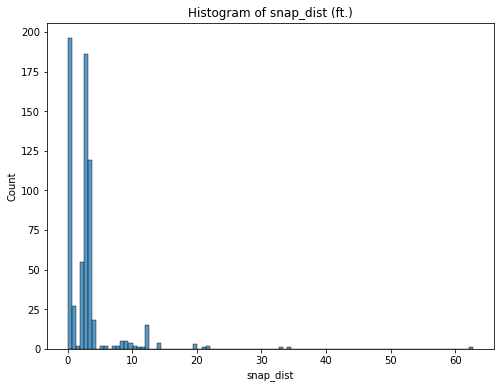

In [32]:
plt.figure(figsize=(8, 6))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

<AxesSubplot:>

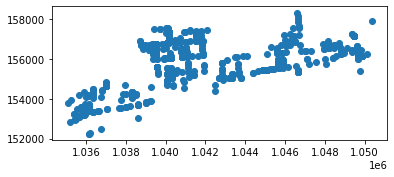

In [33]:
updated_points = gpd.GeoDataFrame(
    updated_points,
    geometry='point'
)

updated_points.plot()

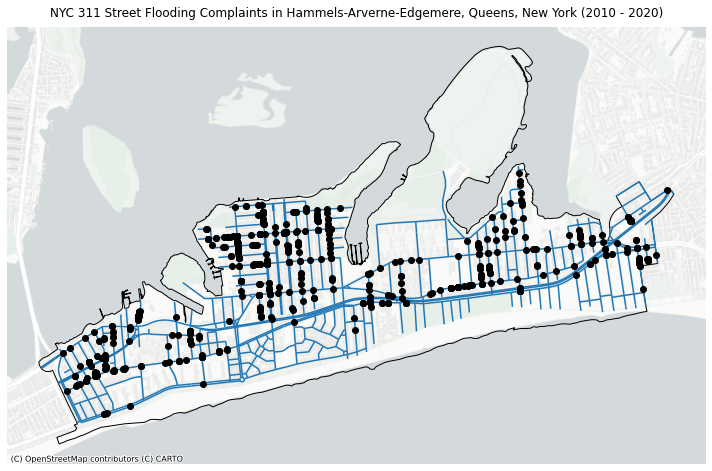

In [34]:
fig, ax = plt.subplots(figsize=(10,10))

updated_points.plot(
    color='black',
    edgecolor='black',
    ax=ax,
    zorder=3
)

streets_clipped.plot(ax=ax, zorder=2)
(nta_gdf
 .loc[nta_gdf.ntaname == 'Hammels-Arverne-Edgemere']
 .plot(ax=ax, 
       zorder=1, 
       color='None', 
       edgecolor='black')
)

# adding basemap
ctx.add_basemap(ax, crs=2263, source=ctx.providers.CartoDB.PositronNoLabels, zorder=0)

# setting title
label = 'NYC 311 Street Flooding Complaints in Hammels-Arverne-Edgemere, Queens, New York (2010 - 2020)'
ax.set_title(label, fontsize=12, pad=10)

plt.axis('off')
plt.tight_layout()
plt.savefig('figures/casestudies_2.png', bbox_inches='tight')

In [35]:
gdf_count = (
    updated_points
     .groupby(by='physicalid')['created_date']
     .count()
     .reset_index()
     .rename(columns={"created_date": "count"})
)

gdf_count.head()

,physicalid,count
0,101236,2
1,102480,1
2,104183,11
3,104184,4
4,104185,1


In [36]:
streets_clipped['new_geom'] = streets_clipped['geometry'].buffer(40, cap_style=2)
streets_clipped = streets_clipped.set_geometry('new_geom')

streets_clipped.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,new_geom
0,101068,BCH 51 ST,51,BCH 51 ST,1,Street,30.0,13,13,4,176.231741,"LINESTRING (1044956.113 154586.354, 1044933.33...","POLYGON ((1044893.669 154755.937, 1044972.998 ..."
1,101235,BCH BREEZE PL,BREEZE,BCH BREEZE PL,1,Street,30.0,13,13,4,269.551133,"LINESTRING (1038994.245 154057.699, 1038962.96...","POLYGON ((1038923.231 154320.786, 1039002.691 ..."
2,101236,BCH BREEZE PL,BREEZE,BCH BREEZE PL,1,Street,30.0,13,13,4,257.108466,"LINESTRING (1039024.286 153802.352, 1038994.24...","POLYGON ((1038954.519 154053.026, 1039033.971 ..."
3,101237,AQUATIC PL,AQUATIC,AQUATIC PL,1,Street,30.0,13,13,4,206.923622,"LINESTRING (1039237.134 153876.531, 1039211.64...","POLYGON ((1039171.947 154076.950, 1039251.338 ..."
4,101413,BCH 53 ST,53,BCH 53 ST,1,Street,30.0,13,13,4,885.400917,"LINESTRING (1044412.704 155295.577, 1044344.50...","POLYGON ((1044304.627 156175.266, 1044384.389 ..."


In [37]:
# joining our nta population data to our nta shapes data
streets_with_count = streets_clipped.merge(
    gdf_count, 
    left_on='physicalid', 
    right_on='physicalid', 
    how='left'
)

streets_with_count['count'] = streets_with_count['count'].fillna(0)

streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 873 entries, 0 to 872
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    873 non-null    object  
 1   st_label      873 non-null    object  
 2   st_name       873 non-null    object  
 3   full_stree    873 non-null    object  
 4   rw_type       873 non-null    object  
 5   rw_type_name  873 non-null    object  
 6   st_width      873 non-null    object  
 7   frm_lvl_co    873 non-null    object  
 8   to_lvl_co     873 non-null    object  
 9   borocode      873 non-null    object  
 10  shape_leng    873 non-null    float64 
 11  geometry      873 non-null    geometry
 12  new_geom      873 non-null    geometry
 13  count         873 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 102.3+ KB


In [38]:
streets_with_count.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,new_geom,count
0,101068,BCH 51 ST,51,BCH 51 ST,1,Street,30.0,13,13,4,176.231741,"LINESTRING (1044956.113 154586.354, 1044933.33...","POLYGON ((1044893.669 154755.937, 1044972.998 ...",0.0
1,101235,BCH BREEZE PL,BREEZE,BCH BREEZE PL,1,Street,30.0,13,13,4,269.551133,"LINESTRING (1038994.245 154057.699, 1038962.96...","POLYGON ((1038923.231 154320.786, 1039002.691 ...",0.0
2,101236,BCH BREEZE PL,BREEZE,BCH BREEZE PL,1,Street,30.0,13,13,4,257.108466,"LINESTRING (1039024.286 153802.352, 1038994.24...","POLYGON ((1038954.519 154053.026, 1039033.971 ...",2.0
3,101237,AQUATIC PL,AQUATIC,AQUATIC PL,1,Street,30.0,13,13,4,206.923622,"LINESTRING (1039237.134 153876.531, 1039211.64...","POLYGON ((1039171.947 154076.950, 1039251.338 ...",0.0
4,101413,BCH 53 ST,53,BCH 53 ST,1,Street,30.0,13,13,4,885.400917,"LINESTRING (1044412.704 155295.577, 1044344.50...","POLYGON ((1044304.627 156175.266, 1044384.389 ...",0.0


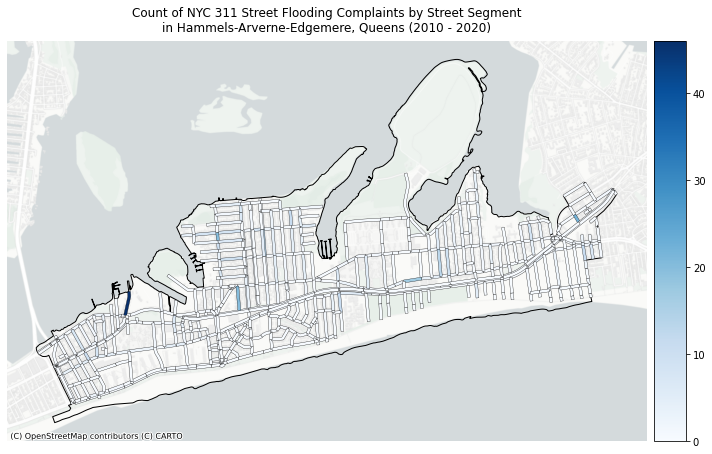

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))

# resizing the color bar to scale to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

streets_with_count.plot(
    column='count', 
    ax=ax,
    cax=cax, 
    zorder=2,                        
    cmap='Blues',
    edgecolor='black',
    linewidth=.3,
    legend=True
)

(nta_gdf
 .loc[nta_gdf.ntaname == 'Hammels-Arverne-Edgemere']
 .plot(ax=ax, 
       zorder=1, 
       color='None', 
       edgecolor='black')
)

# adding basemap
ctx.add_basemap(ax, crs=2263, source=ctx.providers.CartoDB.PositronNoLabels, zorder=0)

# setting title
label = 'Count of NYC 311 Street Flooding Complaints by Street Segment\n\
in Hammels-Arverne-Edgemere, Queens (2010 - 2020)'
ax.set_title(label=label, fontsize=12, pad=10)

ax.axis('off')
plt.tight_layout()
plt.savefig('figures/casestudies_3.png', bbox_inches='tight')

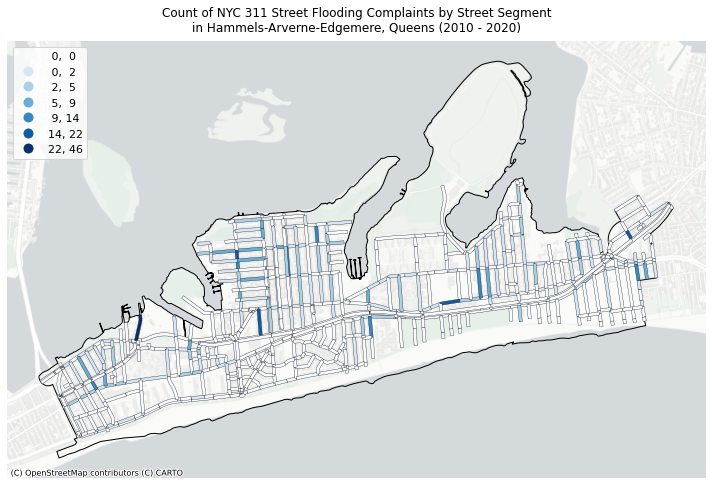

In [40]:
fig, ax = plt.subplots(figsize=(10, 10)) 

streets_with_count.plot(
    column='count', 
    ax=ax, 
    zorder=2,                        
    cmap='Blues',
    edgecolor='black',
    linewidth=.3,
    legend=True, 
    scheme='fisherjenks',
    k=7,
    legend_kwds={'loc': "upper left", 'fmt': "{:,.0f}", 'fontsize': "11"}
)

(nta_gdf
 .loc[nta_gdf.ntaname == 'Hammels-Arverne-Edgemere']
 .plot(
     ax=ax, 
     zorder=1, 
     color='None', 
     edgecolor='black')
 )

# adding basemap
ctx.add_basemap(
    ax, 
    crs=2263, 
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0
)

# setting title
label = 'Count of NYC 311 Street Flooding Complaints by Street Segment\n\
in Hammels-Arverne-Edgemere, Queens (2010 - 2020)'
ax.set_title(label, fontsize=12, pad=10)

plt.axis('off')
plt.tight_layout()
plt.savefig('figures/casestudies_4.png', bbox_inches='tight')

In [41]:
streets_with_count['shape_leng'] = streets_with_count['geometry'].length
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,new_geom,count,count_per_100ft
0,101068,BCH 51 ST,51,BCH 51 ST,1,Street,30.0,13,13,4,176.231741,"LINESTRING (1044956.113 154586.354, 1044933.33...","POLYGON ((1044893.669 154755.937, 1044972.998 ...",0.0,0.000000
1,101235,BCH BREEZE PL,BREEZE,BCH BREEZE PL,1,Street,30.0,13,13,4,269.551133,"LINESTRING (1038994.245 154057.699, 1038962.96...","POLYGON ((1038923.231 154320.786, 1039002.691 ...",0.0,0.000000
2,101236,BCH BREEZE PL,BREEZE,BCH BREEZE PL,1,Street,30.0,13,13,4,257.108466,"LINESTRING (1039024.286 153802.352, 1038994.24...","POLYGON ((1038954.519 154053.026, 1039033.971 ...",2.0,0.777882
3,101237,AQUATIC PL,AQUATIC,AQUATIC PL,1,Street,30.0,13,13,4,206.923622,"LINESTRING (1039237.134 153876.531, 1039211.64...","POLYGON ((1039171.947 154076.950, 1039251.338 ...",0.0,0.000000
4,101413,BCH 53 ST,53,BCH 53 ST,1,Street,30.0,13,13,4,885.400917,"LINESTRING (1044412.704 155295.577, 1044344.50...","POLYGON ((1044304.627 156175.266, 1044384.389 ...",0.0,0.000000


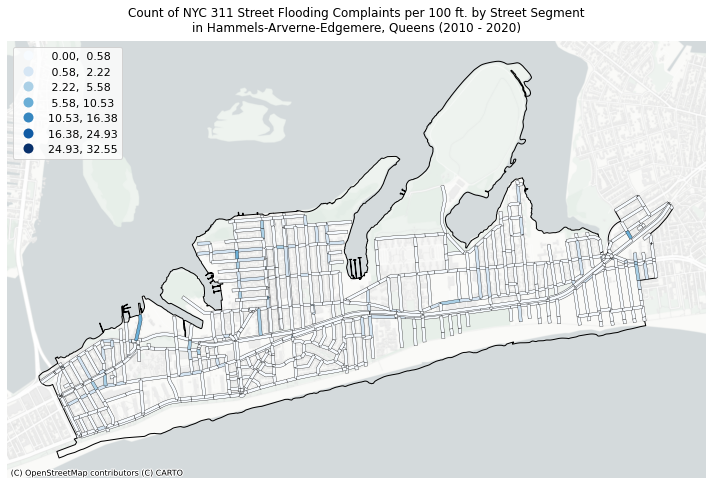

In [42]:
fig, ax = plt.subplots(figsize=(10, 10)) 

streets_with_count.plot(
    column='count_per_100ft', 
    ax=ax, # plotting on the generated axis
    zorder=2,                        
    cmap='Blues',
    edgecolor='black',
    linewidth=.3,
    legend=True, 
    scheme='fisherjenks',
    k=7,
    legend_kwds={'loc': "upper left", 
                 'fmt': "{:,.2f}",
                 'fontsize': "11"}
)

(nta_gdf
 .loc[nta_gdf.ntaname == 'Hammels-Arverne-Edgemere']
 .plot(ax=ax, 
        zorder=1, 
        color='None', 
        edgecolor='black')
)

# adding basemap
ctx.add_basemap(
    ax, 
    crs=2263, 
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0
)

# setting title
label = 'Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment\n\
in Hammels-Arverne-Edgemere, Queens (2010 - 2020)'
ax.set_title(label, fontsize=12, pad=10)

plt.axis('off')
plt.tight_layout()

plt.savefig('figures/casestudies_5.png', bbox_inches='tight')

In [43]:
streets_with_count['street_and_id'] = (
    streets_with_count['full_stree']
    + ', id:'
    + streets_with_count['physicalid']
)

streets_with_count.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,new_geom,count,count_per_100ft,street_and_id
0,101068,BCH 51 ST,51,BCH 51 ST,1,Street,30.0,13,13,4,176.231741,"LINESTRING (1044956.113 154586.354, 1044933.33...","POLYGON ((1044893.669 154755.937, 1044972.998 ...",0.0,0.000000,"BCH 51 ST, id:101068"
1,101235,BCH BREEZE PL,BREEZE,BCH BREEZE PL,1,Street,30.0,13,13,4,269.551133,"LINESTRING (1038994.245 154057.699, 1038962.96...","POLYGON ((1038923.231 154320.786, 1039002.691 ...",0.0,0.000000,"BCH BREEZE PL, id:101235"
2,101236,BCH BREEZE PL,BREEZE,BCH BREEZE PL,1,Street,30.0,13,13,4,257.108466,"LINESTRING (1039024.286 153802.352, 1038994.24...","POLYGON ((1038954.519 154053.026, 1039033.971 ...",2.0,0.777882,"BCH BREEZE PL, id:101236"
3,101237,AQUATIC PL,AQUATIC,AQUATIC PL,1,Street,30.0,13,13,4,206.923622,"LINESTRING (1039237.134 153876.531, 1039211.64...","POLYGON ((1039171.947 154076.950, 1039251.338 ...",0.0,0.000000,"AQUATIC PL, id:101237"
4,101413,BCH 53 ST,53,BCH 53 ST,1,Street,30.0,13,13,4,885.400917,"LINESTRING (1044412.704 155295.577, 1044344.50...","POLYGON ((1044304.627 156175.266, 1044384.389 ...",0.0,0.000000,"BCH 53 ST, id:101413"


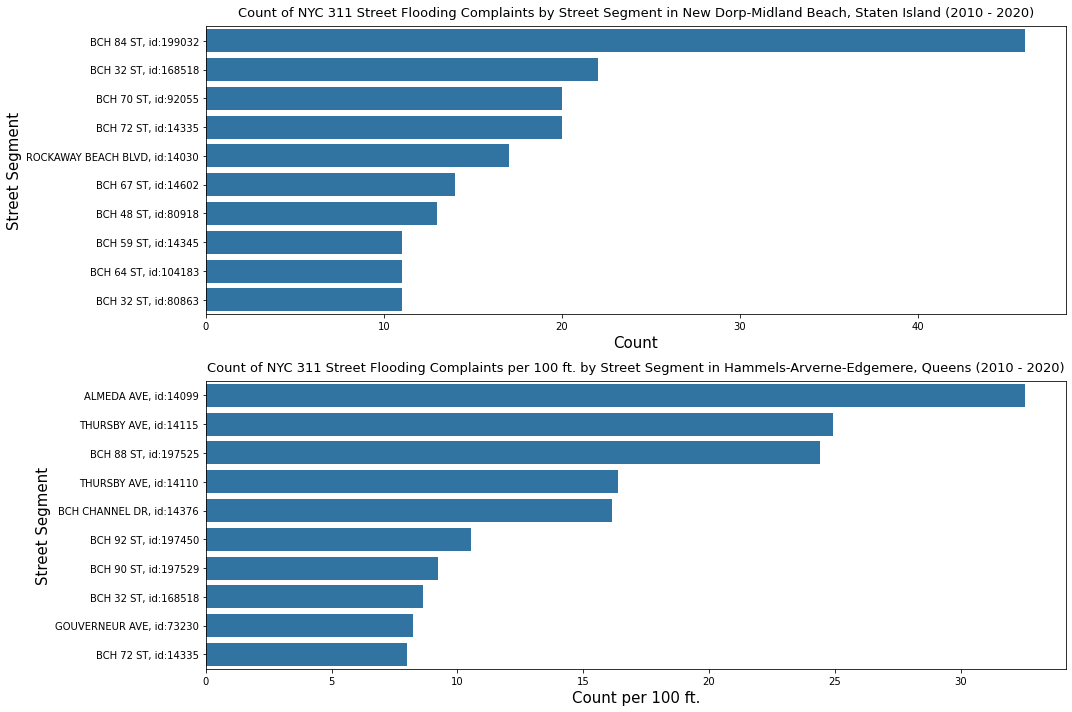

In [44]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(15, 10))

# first plot
data = streets_with_count.sort_values(by='count', ascending=False).head(10)
sns.barplot(
    data=data,
    y='street_and_id',
    x='count',
    color='#1f77b4',
    ax=axs[0]
)

axs[0].set_title('Count of NYC 311 Street Flooding Complaints by Street Segment in New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
          fontsize=13,
          pad=10)
axs[0].set_xlabel('Count', fontsize=15)
axs[0].set_ylabel('Street Segment', fontsize=15)

# second plot
sns.barplot(data=streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(10),
            y='street_and_id',
            x='count_per_100ft',
            color='#1f77b4',
            ax=axs[1])

axs[1].set_title('Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment in Hammels-Arverne-Edgemere, Queens (2010 - 2020)', 
          fontsize=13,
          pad=10)
axs[1].set_xlabel('Count per 100 ft.', fontsize=15)
axs[1].set_ylabel('Street Segment', fontsize=15)

plt.tight_layout()
# plt.savefig('figures/casestudies_11.png', bbox_inches='tight')

## New Dorp - Midland Beach, Staten Island

In [45]:
geometry = gpd.points_from_xy(df['x_coordinate_state_plane'], df['y_coordinate_state_plane'])

gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=2263)

gdf.head()

/Users/markbauer/opt/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_borough,latitude,longitude,location,geometry
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,5.037950e+09,STATEN ISLAND,958363.0,148793.0,ONLINE,STATEN ISLAND,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000)
1,45283863,2019-12-31T17:34:00.000,2020-01-01T15:45:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10312.0,NaN,NaN,...,NaN,STATEN ISLAND,937878.0,143517.0,PHONE,STATEN ISLAND,40.560476,-74.166889,"{'latitude': '40.56047555908232', 'longitude':...",POINT (937878.000 143517.000)
2,45279400,2019-12-31T16:11:00.000,2020-01-08T10:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10305.0,753 QUINCY AVENUE,QUINCY AVENUE,...,5.038260e+09,STATEN ISLAND,960864.0,149333.0,PHONE,STATEN ISLAND,40.576530,-74.084185,"{'latitude': '40.576529751013474', 'longitude'...",POINT (960864.000 149333.000)
3,45277773,2019-12-31T15:42:00.000,2020-01-01T05:25:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11379.0,61-21 70 STREET,70 STREET,...,4.029270e+09,QUEENS,1015410.0,201741.0,PHONE,QUEENS,40.720354,-73.887589,"{'latitude': '40.72035428730757', 'longitude':...",POINT (1015410.000 201741.000)
4,45282532,2019-12-31T12:18:00.000,2019-12-31T14:15:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11375.0,NaN,NaN,...,NaN,QUEENS,1027498.0,202160.0,PHONE,QUEENS,40.721454,-73.843978,"{'latitude': '40.721453503515995', 'longitude'...",POINT (1027498.000 202160.000)


In [46]:
gdf = gpd.sjoin(
    gdf, 
    nta_gdf, 
    how="inner", 
    op='within'
)

gdf.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,location,geometry,index_right,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5
9,45279697,2019-12-31T07:10:00.000,2019-12-31T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5
68,45196140,2019-12-18T15:58:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,101 3 STREET,3 STREET,...,"{'latitude': '40.57522353925495', 'longitude':...",POINT (951437.000 148868.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5
79,45188340,2019-12-18T10:16:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,15 LISBON PLACE,LISBON PLACE,...,"{'latitude': '40.5817739850288', 'longitude': ...",POINT (954138.000 151251.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5
80,45188337,2019-12-18T09:30:00.000,2019-12-18T19:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000),81,SI45,55448202.1327,085,New Dorp-Midland Beach,34369.8892724,Staten Island,5


In [47]:
gdf = gdf.drop(columns=["shape_leng", 'shape_area'])

gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 24814 entries, 0 to 24703
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      24814 non-null  int64   
 1   created_date                    24814 non-null  object  
 2   closed_date                     24812 non-null  object  
 3   agency                          24814 non-null  object  
 4   agency_name                     24814 non-null  object  
 5   complaint_type                  24814 non-null  object  
 6   descriptor                      24814 non-null  object  
 7   incident_zip                    24814 non-null  float64 
 8   incident_address                16002 non-null  object  
 9   street_name                     16002 non-null  object  
 10  cross_street_1                  21821 non-null  object  
 11  cross_street_2                  21816 non-null  object  
 12  address_ty

<AxesSubplot:>

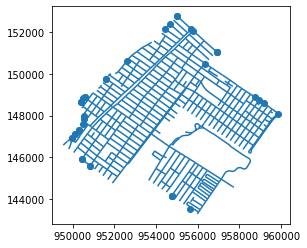

In [48]:
New_Dorp_Midland_Beach = nta_gdf.loc[nta_gdf.ntaname == 'New Dorp-Midland Beach']

# clipping the school points that only fall within the nta shapes
streets_clipped = gpd.clip(streets, New_Dorp_Midland_Beach)

streets_clipped.plot()

In [49]:
streets_clipped.geom_type.value_counts()

LineString            725
Point                  33
GeometryCollection      5
MultiLineString         1
dtype: int64

In [50]:
streets_clipped = streets_clipped.loc[streets_clipped.geom_type == 'LineString']

streets_clipped.geom_type.value_counts()

LineString    725
dtype: int64

<AxesSubplot:>

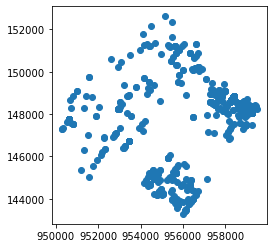

In [51]:
# clipping the points that only fall within the nta shapes
New_Dorp_Midland_Beach = gpd.clip(gdf, New_Dorp_Midland_Beach)

New_Dorp_Midland_Beach.plot()

In [52]:
New_Dorp_Midland_Beach.geom_type.value_counts()

Point    690
dtype: int64

# Snap points to lines

https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

In [53]:
offset = 80
bbox = New_Dorp_Midland_Beach.bounds + [-offset, -offset, offset, offset]
hits = bbox.apply(lambda row: list(streets_clipped.sindex.intersection(row)), axis=1)

hits.head()

0          [563, 554, 562, 289]
9          [563, 554, 562, 289]
68    [656, 254, 691, 255, 657]
79                        [711]
80         [563, 554, 562, 289]
dtype: object

In [54]:
tmp = pd.DataFrame({
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    "line_i": np.concatenate(hits.values)
})

# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(
    streets_clipped.reset_index(drop=True),
    on="line_i"
)

tmp.head()

,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry
0,0,563.0,76942,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,32.0,13,13,5,197.483266,"LINESTRING (958315.407 148720.726, 958202.845 ..."
1,0,554.0,76094,MAPLETON AVE,MAPLETON,MAPLETON AVE,1,Street,18.0,13,13,5,251.356615,"LINESTRING (958315.407 148720.726, 958524.763 ..."
2,0,562.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,"LINESTRING (958533.722 149022.897, 958315.407 ..."
3,0,289.0,52063,NUGENT AVE,NUGENT,NUGENT AVE,1,Street,38.0,13,13,5,556.903050,"LINESTRING (958315.973 149159.852, 957997.235 ..."
4,9,563.0,76942,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,32.0,13,13,5,197.483266,"LINESTRING (958315.407 148720.726, 958202.845 ..."


In [55]:
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(
    New_Dorp_Midland_Beach.geometry.rename("point"),
    on="pt_idx"
)

# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(
    tmp,
    geometry="geometry",
    crs=New_Dorp_Midland_Beach.crs
)

tmp.head()

,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point
0,0,563.0,76942,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,32.0,13,13,5,197.483266,"LINESTRING (958315.407 148720.726, 958202.845 ...",POINT (958363.000 148793.000)
1,0,554.0,76094,MAPLETON AVE,MAPLETON,MAPLETON AVE,1,Street,18.0,13,13,5,251.356615,"LINESTRING (958315.407 148720.726, 958524.763 ...",POINT (958363.000 148793.000)
2,0,562.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,"LINESTRING (958533.722 149022.897, 958315.407 ...",POINT (958363.000 148793.000)
3,0,289.0,52063,NUGENT AVE,NUGENT,NUGENT AVE,1,Street,38.0,13,13,5,556.903050,"LINESTRING (958315.973 149159.852, 957997.235 ...",POINT (958363.000 148793.000)
4,9,563.0,76942,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,32.0,13,13,5,197.483266,"LINESTRING (958315.407 148720.726, 958202.845 ...",POINT (958363.000 148793.000)


In [56]:
tmp["snap_dist"] = tmp['geometry'].distance(gpd.GeoSeries(tmp.point))

# Discard any lines that are greater than tolerance from points
tmp = (
    tmp
    .loc[tmp.snap_dist <= offset]
    .sort_values(by=["snap_dist"])
)

tmp.head()

,pt_idx,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
1443,16933,116.0,173628,CEDAR GROVE AVE,CEDAR GROVE,CEDAR GROVE AVE,1,Street,30.0,13,13,5,81.013544,"LINESTRING (956774.728 144439.828, 956728.977 ...",POINT (956729.000 144373.000),0.001732
2159,21386,376.0,53940,FREEBORN ST,FREEBORN,FREEBORN ST,1,Street,30.0,13,13,5,379.453064,"LINESTRING (958104.215 147999.309, 957884.712 ...",POINT (958104.000 147999.000),0.003294
235,2101,571.0,84599,ROSE AVE,ROSE,ROSE AVE,1,Street,30.0,13,13,5,249.365873,"LINESTRING (951137.861 148456.727, 951338.494 ...",POINT (951338.000 148309.000),0.003960
559,5274,292.0,52066,KISWICK ST,KISWICK,KISWICK ST,1,Street,32.0,13,13,5,509.998826,"LINESTRING (957795.024 148848.019, 957495.893 ...",POINT (957795.000 148848.000),0.008792
555,5243,292.0,52066,KISWICK ST,KISWICK,KISWICK ST,1,Street,32.0,13,13,5,509.998826,"LINESTRING (957795.024 148848.019, 957495.893 ...",POINT (957795.000 148848.000),0.008792


In [57]:
# group by the index of the points and take the first, which is the closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
pt_idx,,,,,,,,,,,,,,,
0,562.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,"LINESTRING (958533.722 149022.897, 958315.407 ...",POINT (958363.000 148793.000),3.748273
9,562.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,"LINESTRING (958533.722 149022.897, 958315.407 ...",POINT (958363.000 148793.000),3.748273
68,657.0,89719,3 ST,3,3 ST,1,Street,30.0,13,13,5,204.368178,"LINESTRING (951507.590 148960.030, 951387.141 ...",POINT (951437.000 148868.000),2.787056
79,711.0,98849,LISBON PL,LISBON,LISBON PL,1,Street,30.0,13,13,5,308.463539,"LINESTRING (954222.466 151355.690, 954034.853 ...",POINT (954138.000 151251.000),3.372281
80,562.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,"LINESTRING (958533.722 149022.897, 958315.407 ...",POINT (958363.000 148793.000),3.748273


In [58]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

# Create a new GeoDataFrame from the columns from the closest line and new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

/Users/markbauer/opt/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/array.py:640: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vectorized.interpolate(self.data, distance, normalized=normalized),


,line_i,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
pt_idx,,,,,,,,,,,,,,,
0,562.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273
9,562.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273
68,657.0,89719,3 ST,3,3 ST,1,Street,30.0,13,13,5,204.368178,POINT (951439.252 148866.357),POINT (951437.000 148868.000),2.787056
79,711.0,98849,LISBON PL,LISBON,LISBON PL,1,Street,30.0,13,13,5,308.463539,POINT (954140.677 151248.949),POINT (954138.000 151251.000),3.372281
80,562.0,76941,GRIMSBY ST,GRIMSBY,GRIMSBY ST,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273


In [59]:
New_Dorp_Midland_Beach.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,latitude,longitude,location,geometry,index_right,ntacode,county_fips,ntaname,boro_name,boro_code
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000),81,SI45,085,New Dorp-Midland Beach,Staten Island,5
9,45279697,2019-12-31T07:10:00.000,2019-12-31T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000),81,SI45,085,New Dorp-Midland Beach,Staten Island,5
68,45196140,2019-12-18T15:58:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,101 3 STREET,3 STREET,...,40.575224,-74.118117,"{'latitude': '40.57522353925495', 'longitude':...",POINT (951437.000 148868.000),81,SI45,085,New Dorp-Midland Beach,Staten Island,5
79,45188340,2019-12-18T10:16:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,15 LISBON PLACE,LISBON PLACE,...,40.581774,-74.108405,"{'latitude': '40.5817739850288', 'longitude': ...",POINT (954138.000 151251.000),81,SI45,085,New Dorp-Midland Beach,Staten Island,5
80,45188337,2019-12-18T09:30:00.000,2019-12-18T19:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':...",POINT (958363.000 148793.000),81,SI45,085,New Dorp-Midland Beach,Staten Island,5


In [60]:
New_Dorp_Midland_Beach.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 690 entries, 0 to 24787
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      690 non-null    int64   
 1   created_date                    690 non-null    object  
 2   closed_date                     690 non-null    object  
 3   agency                          690 non-null    object  
 4   agency_name                     690 non-null    object  
 5   complaint_type                  690 non-null    object  
 6   descriptor                      690 non-null    object  
 7   incident_zip                    690 non-null    float64 
 8   incident_address                481 non-null    object  
 9   street_name                     481 non-null    object  
 10  cross_street_1                  614 non-null    object  
 11  cross_street_2                  612 non-null    object  
 12  address_type

In [61]:
New_Dorp_Midland_Beach = New_Dorp_Midland_Beach.drop(columns=["geometry"])

New_Dorp_Midland_Beach.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,park_borough,latitude,longitude,location,index_right,ntacode,county_fips,ntaname,boro_name,boro_code
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,STATEN ISLAND,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':...",81,SI45,085,New Dorp-Midland Beach,Staten Island,5
9,45279697,2019-12-31T07:10:00.000,2019-12-31T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,STATEN ISLAND,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':...",81,SI45,085,New Dorp-Midland Beach,Staten Island,5
68,45196140,2019-12-18T15:58:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,101 3 STREET,3 STREET,...,STATEN ISLAND,40.575224,-74.118117,"{'latitude': '40.57522353925495', 'longitude':...",81,SI45,085,New Dorp-Midland Beach,Staten Island,5
79,45188340,2019-12-18T10:16:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,15 LISBON PLACE,LISBON PLACE,...,STATEN ISLAND,40.581774,-74.108405,"{'latitude': '40.5817739850288', 'longitude': ...",81,SI45,085,New Dorp-Midland Beach,Staten Island,5
80,45188337,2019-12-18T09:30:00.000,2019-12-18T19:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,STATEN ISLAND,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':...",81,SI45,085,New Dorp-Midland Beach,Staten Island,5


In [62]:
# Join back to the original points:
updated_points = (
    New_Dorp_Midland_Beach
    .join(snapped)
    .dropna(subset=["geometry"])
)

updated_points.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,point,snap_dist
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273
9,45279697,2019-12-31T07:10:00.000,2019-12-31T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273
68,45196140,2019-12-18T15:58:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,101 3 STREET,3 STREET,...,1,Street,30.0,13,13,5,204.368178,POINT (951439.252 148866.357),POINT (951437.000 148868.000),2.787056
79,45188340,2019-12-18T10:16:00.000,2019-12-20T09:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,15 LISBON PLACE,LISBON PLACE,...,1,Street,30.0,13,13,5,308.463539,POINT (954140.677 151248.949),POINT (954138.000 151251.000),3.372281
80,45188337,2019-12-18T09:30:00.000,2019-12-18T19:30:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,1,Street,22.0,13,13,5,372.785694,POINT (958366.038 148790.805),POINT (958363.000 148793.000),3.748273


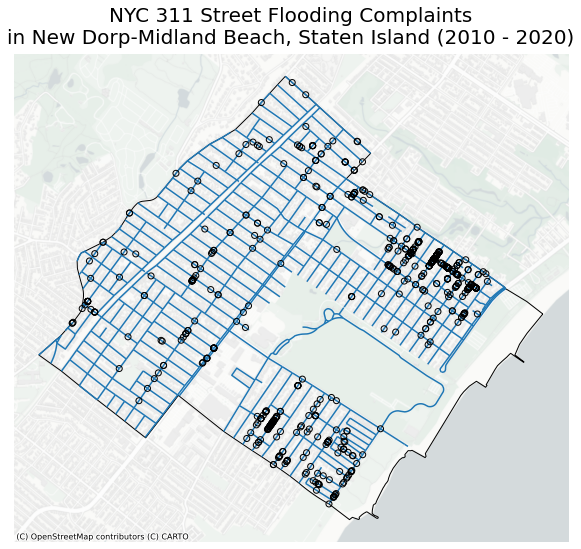

In [63]:
fig, ax = plt.subplots(figsize=(8, 8)) # creating a figure

updated_points.plot(
    color='none', 
    edgecolor='black',
    ax=ax,
    zorder=3
)

streets_clipped.plot(ax=ax, zorder=2)

(nta_gdf
 .loc[nta_gdf.ntaname == 'New Dorp-Midland Beach']
 .plot(
     ax=ax, 
     zorder=1, 
     color='None', 
     edgecolor='black')
)

# adding basemap
ctx.add_basemap(
    ax, 
    crs=2263, 
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0
)

# setting title
label = 'NYC 311 Street Flooding Complaints\nin New Dorp-Midland Beach, Staten Island (2010 - 2020)'
ax.set_title(label, fontsize=20, pad=10)

plt.axis('off')
plt.tight_layout()
plt.savefig('figures/casestudies_7.png', bbox_inches='tight')

In [64]:
gdf_count = (
    updated_points
    .groupby(by='physicalid')['created_date']
    .count()
    .reset_index()
    .rename(columns={"created_date": "count"})
)
gdf_count.head()

,physicalid,count
0,100411,1
1,100451,1
2,100452,2
3,100822,8
4,100863,2


In [65]:
streets_clipped = streets_clipped.set_geometry('geometry')
streets_clipped['new_geom'] = streets_clipped['geometry'].buffer(40, cap_style=2)
streets_clipped = streets_clipped.set_geometry('new_geom')

streets_clipped.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,new_geom
284,100298,STEELE AVE,STEELE,STEELE AVE,1,Street,26.0,13,13,5,624.666956,"LINESTRING (951650.197 149152.904, 952160.439 ...","POLYGON ((952183.515 148825.213, 952137.364 14..."
285,100299,STEELE AVE,STEELE,STEELE AVE,1,Street,26.0,13,13,5,388.883197,"LINESTRING (951334.131 149379.470, 951650.197 ...","POLYGON ((951673.501 149185.414, 951626.893 14..."
392,100411,TOPPING ST,TOPPING,TOPPING ST,1,Street,16.0,13,13,5,680.344874,"LINESTRING (956012.033 144532.831, 956563.778 ...","POLYGON ((956587.181 144167.217, 956540.375 14..."
396,100415,HAVEN AVE,HAVEN,HAVEN AVE,1,Street,25.0,13,13,5,190.500775,"LINESTRING (956885.362 150139.082, 956885.362 ...","POLYGON ((956916.701 150114.226, 956854.022 15..."
427,100450,HETT AVE,HETT,HETT AVE,1,Street,30.0,13,13,5,540.694801,"LINESTRING (956247.755 145507.098, 955936.222 ...","POLYGON ((955968.915 145042.126, 955903.529 14..."


In [66]:
# joining our nta population data to our nta shapes data
streets_with_count = streets_clipped.merge(
    gdf_count, 
    left_on='physicalid', 
    right_on='physicalid', 
    how='left'
)

streets_with_count['count'].fillna(0)

streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 725 entries, 0 to 724
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    725 non-null    object  
 1   st_label      725 non-null    object  
 2   st_name       725 non-null    object  
 3   full_stree    725 non-null    object  
 4   rw_type       725 non-null    object  
 5   rw_type_name  725 non-null    object  
 6   st_width      725 non-null    object  
 7   frm_lvl_co    725 non-null    object  
 8   to_lvl_co     725 non-null    object  
 9   borocode      725 non-null    object  
 10  shape_leng    725 non-null    float64 
 11  geometry      725 non-null    geometry
 12  new_geom      725 non-null    geometry
 13  count         175 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 85.0+ KB


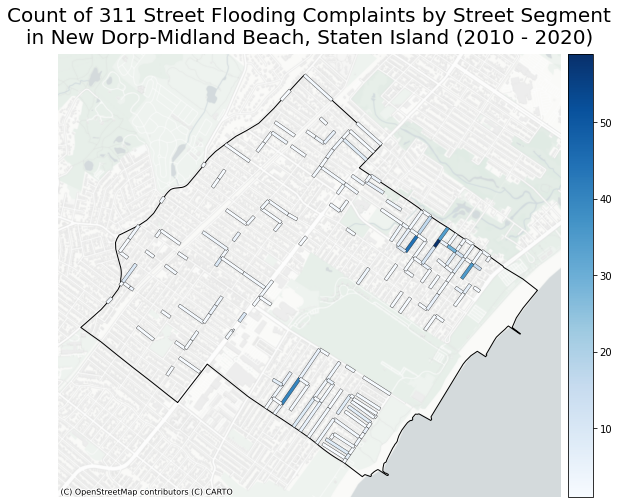

In [67]:
fig, ax = plt.subplots(figsize=(8, 8)) # creating figure

# saving variable to format integers as strings with commas
comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))

# resizing the color bar to scale to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(
    column='count', 
    ax=ax, # plotting on the generated axis
    cax=cax, # legend of the color bar
    zorder=2,                        
    cmap='Blues',
    edgecolor='black',
    linewidth=.3,
    legend=True
)

(nta_gdf
 .loc[nta_gdf.ntaname == 'New Dorp-Midland Beach']
 .plot(
     ax=ax, 
     zorder=1, 
     color='None', 
     edgecolor='black')
)

# adding basemap
ctx.add_basemap(
    ax, 
    crs=2263, 
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0
)


# setting title
label = 'Count of 311 Street Flooding Complaints by Street Segment\n\
in New Dorp-Midland Beach, Staten Island (2010 - 2020)'
ax.set_title(label, fontsize=20, pad=10)

ax.axis('off')
plt.tight_layout()
plt.savefig('figures/casestudies_8.png', bbox_inches='tight')

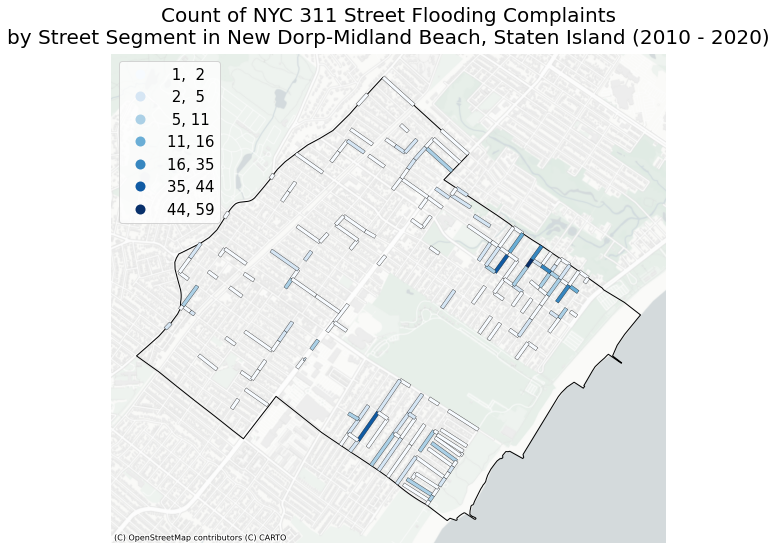

In [68]:
fig, ax = plt.subplots(figsize=(8, 8)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(
    column='count', 
    ax=ax, # plotting on the generated axis
    zorder=2,
    cmap='Blues',
    edgecolor='black',
    linewidth=.3,
    legend=True, 
    scheme='fisherjenks',
    k=7,
    legend_kwds={'loc': "upper left", 
                          'fmt': "{:,.0f}",
                          'fontsize': "15"}
)

(nta_gdf
 .loc[nta_gdf.ntaname == 'New Dorp-Midland Beach']
 .plot(
     ax=ax, 
     zorder=1, 
     color='None', 
     edgecolor='black')
)

# adding basemap
ctx.add_basemap(
    ax, 
    crs=2263, 
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0
)

# setting title
label = 'Count of NYC 311 Street Flooding Complaints\n\
by Street Segment in New Dorp-Midland Beach, Staten Island (2010 - 2020)'
ax.set_title(label=label, fontsize=20, pad=10)

ax.axis('off')
plt.tight_layout()
plt.savefig('figures/casestudies_9.png', bbox_inches='tight')

In [69]:
streets_with_count['shape_leng'] = streets_with_count.geometry.length
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,new_geom,count,count_per_100ft
0,100298,STEELE AVE,STEELE,STEELE AVE,1,Street,26.0,13,13,5,1409.333912,"LINESTRING (951650.197 149152.904, 952160.439 ...","POLYGON ((952183.515 148825.213, 952137.364 14...",NaN,NaN
1,100299,STEELE AVE,STEELE,STEELE AVE,1,Street,26.0,13,13,5,937.766394,"LINESTRING (951334.131 149379.470, 951650.197 ...","POLYGON ((951673.501 149185.414, 951626.893 14...",NaN,NaN
2,100411,TOPPING ST,TOPPING,TOPPING ST,1,Street,16.0,13,13,5,1520.689749,"LINESTRING (956012.033 144532.831, 956563.778 ...","POLYGON ((956587.181 144167.217, 956540.375 14...",1.0,0.06576
3,100415,HAVEN AVE,HAVEN,HAVEN AVE,1,Street,25.0,13,13,5,160.000612,"LINESTRING (956885.362 150139.082, 956885.362 ...","POLYGON ((956916.701 150114.226, 956854.022 15...",NaN,NaN
4,100450,HETT AVE,HETT,HETT AVE,1,Street,30.0,13,13,5,1241.389603,"LINESTRING (956247.755 145507.098, 955936.222 ...","POLYGON ((955968.915 145042.126, 955903.529 14...",NaN,NaN


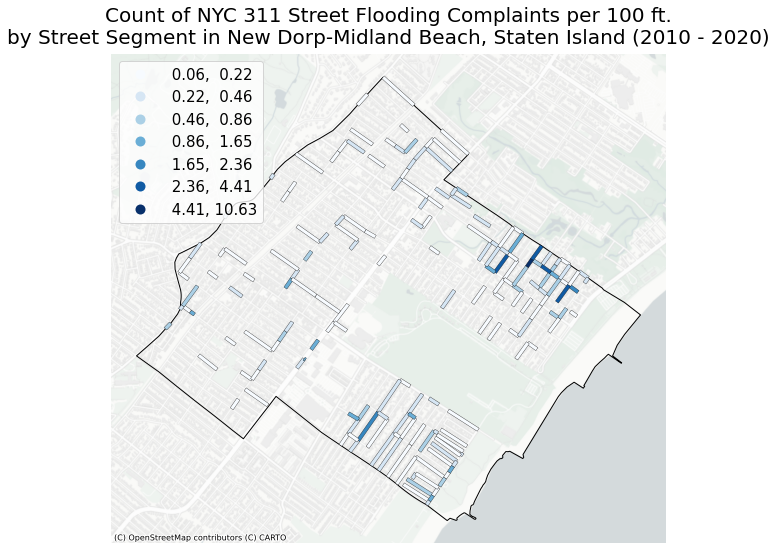

In [70]:
fig, ax = plt.subplots(figsize=(8, 8))


streets_with_count.plot(
    column='count_per_100ft', 
    ax=ax, 
    zorder=2,
    cmap='Blues',
    edgecolor='black',
    linewidth=.3,
    legend=True, 
    scheme='fisherjenks',
    k=7,
    legend_kwds={
        'loc': "upper left", 
         'fmt': "{:,.2f}",
         'fontsize': "15"}
)

(nta_gdf
 .loc[nta_gdf.ntaname == 'New Dorp-Midland Beach']
 .plot(
     ax=ax, 
     zorder=1, 
     color='None', 
     edgecolor='black')
)

# adding basemap
ctx.add_basemap(
    ax, 
    crs=2263, 
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0
)

# setting title
label = 'Count of NYC 311 Street Flooding Complaints per 100 ft.\n\
by Street Segment in New Dorp-Midland Beach, Staten Island (2010 - 2020)'
ax.set_title(label, fontsize=20, pad=10)

ax.axis('off')
plt.tight_layout()
plt.savefig('figures/casestudies_10.png', bbox_inches='tight')

In [71]:
streets_with_count['street_and_id'] = (
    streets_with_count['full_stree']
    + ', id:'
    + streets_with_count['physicalid']
)

streets_with_count.head()

,physicalid,st_label,st_name,full_stree,rw_type,rw_type_name,st_width,frm_lvl_co,to_lvl_co,borocode,shape_leng,geometry,new_geom,count,count_per_100ft,street_and_id
0,100298,STEELE AVE,STEELE,STEELE AVE,1,Street,26.0,13,13,5,1409.333912,"LINESTRING (951650.197 149152.904, 952160.439 ...","POLYGON ((952183.515 148825.213, 952137.364 14...",NaN,NaN,"STEELE AVE, id:100298"
1,100299,STEELE AVE,STEELE,STEELE AVE,1,Street,26.0,13,13,5,937.766394,"LINESTRING (951334.131 149379.470, 951650.197 ...","POLYGON ((951673.501 149185.414, 951626.893 14...",NaN,NaN,"STEELE AVE, id:100299"
2,100411,TOPPING ST,TOPPING,TOPPING ST,1,Street,16.0,13,13,5,1520.689749,"LINESTRING (956012.033 144532.831, 956563.778 ...","POLYGON ((956587.181 144167.217, 956540.375 14...",1.0,0.06576,"TOPPING ST, id:100411"
3,100415,HAVEN AVE,HAVEN,HAVEN AVE,1,Street,25.0,13,13,5,160.000612,"LINESTRING (956885.362 150139.082, 956885.362 ...","POLYGON ((956916.701 150114.226, 956854.022 15...",NaN,NaN,"HAVEN AVE, id:100415"
4,100450,HETT AVE,HETT,HETT AVE,1,Street,30.0,13,13,5,1241.389603,"LINESTRING (956247.755 145507.098, 955936.222 ...","POLYGON ((955968.915 145042.126, 955903.529 14...",NaN,NaN,"HETT AVE, id:100450"


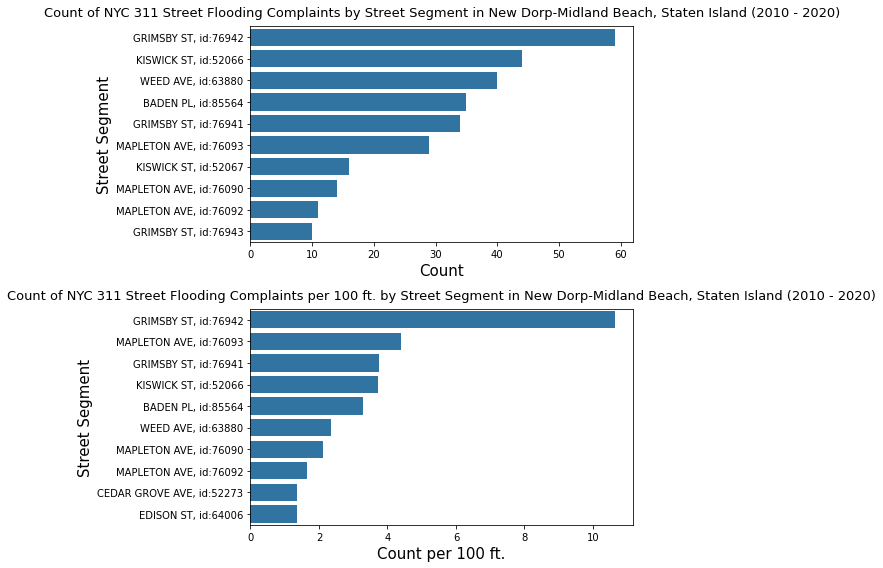

In [72]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(8, 8))

# first plot
data = streets_with_count.sort_values(by='count', ascending=False).head(10)
sns.barplot(
    data=data,
    y='street_and_id',
    x='count',
    color='#1f77b4',
    ax=axs[0]
)

label = 'Count of NYC 311 Street Flooding Complaints by Street Segment \
in New Dorp-Midland Beach, Staten Island (2010 - 2020)'
axs[0].set_title(label, fontsize=13, pad=10)
axs[0].set_xlabel('Count', fontsize=15)
axs[0].set_ylabel('Street Segment', fontsize=15)

# second plot
data = streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(10)
sns.barplot(
    data=data,
    y='street_and_id',
    x='count_per_100ft',
    color='#1f77b4',
    ax=axs[1]
)

label = 'Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment \
in New Dorp-Midland Beach, Staten Island (2010 - 2020)'
axs[1].set_title(label, fontsize=13, pad=10)
axs[1].set_xlabel('Count per 100 ft.', fontsize=15)
axs[1].set_ylabel('Street Segment', fontsize=15)

plt.tight_layout()
plt.savefig('figures/casestudies_11.png', bbox_inches='tight')